# PMFlow v0.2.0 – CNN Baseline Evaluation Notebook

This notebook mirrors the BNN testing flow but focuses on the CNN baselines provided in `nn_lib_v2/pmflow_bnn/baselines.py`. We'll build, train, evaluate, and optionally export a small CNN on MNIST, then compare with a simple MLP baseline. It also demonstrates using the existing PMFlowEvaluator where applicable (e.g., throughput/parallel scaling) even though CNNs don't expose gravitational centers.


In [1]:
# 1) Import Dependencies
import os
import sys
import math
import time
import json
import random
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

# Local library path for nn_lib_v2 (adjust if needed)
root = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parents[0]
lib_path = root / 'programs' / 'demos' / 'machine_learning' / 'nn_lib_v2'
if lib_path.exists():
    sys.path.insert(0, str(lib_path))

try:
    from pmflow_bnn.baselines import CNNBaseline, MLPBaseline
    from pmflow_bnn.evaluation import PMFlowEvaluator
    print("✅ Imported CNN/MLP baselines and evaluator from nn_lib_v2/pmflow_bnn")
except Exception as e:
    print("⚠️ Could not import from local nn_lib_v2. Error:", e)
    CNNBaseline = None
    MLPBaseline = None
    PMFlowEvaluator = None

✅ Imported CNN/MLP baselines and evaluator from nn_lib_v2/pmflow_bnn


In [2]:
# 2) Configure Reproducibility and Device
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using device: cpu


In [3]:
# 3) Load Dataset (MNIST)

data_dir = str((Path.home() / '.torch' / 'datasets').resolve())
transform = transforms.Compose([
    transforms.ToTensor(),  # (1,28,28) in [0,1]
])

train_dataset = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
val_size = 5000
train_size = len(train_dataset) - val_size
train_ds, val_ds = torch.utils.data.random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=device.type=='cuda')
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=device.type=='cuda')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=device.type=='cuda')

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:03<00:00, 3.18MB/s]

100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]

100%|██████████| 1.65M/1.65M [00:01<00:00, 959kB/s]

100%|██████████| 4.54k/4.54k [00:00<00:00, 1.56MB/s]



Train/Val/Test sizes: 55000/5000/10000


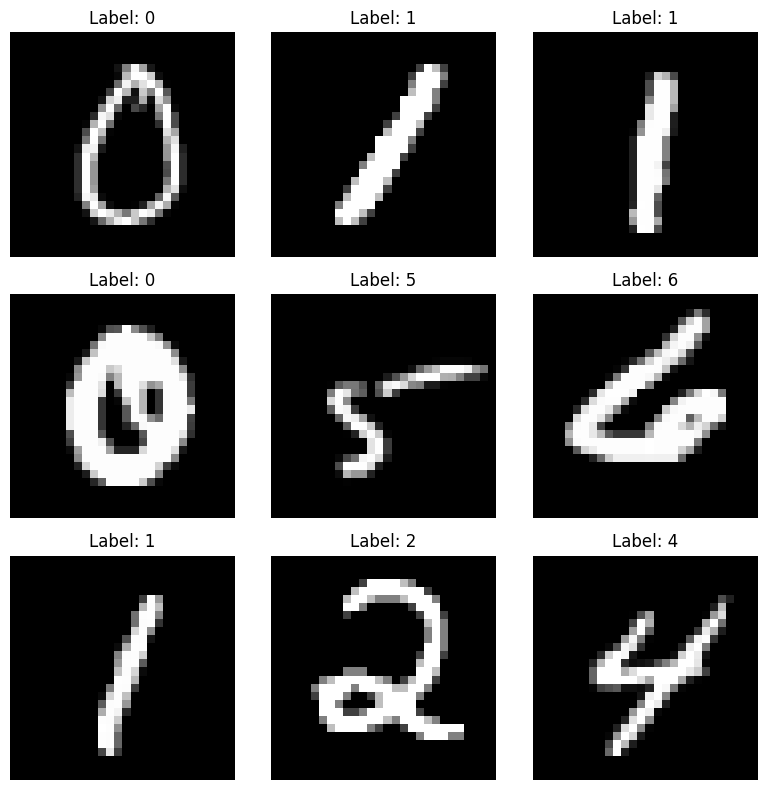

In [4]:
# 4) Inspect and Visualize Samples
classes = [str(i) for i in range(10)]
examples, labels = next(iter(train_loader))

plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(examples[i][0].numpy(), cmap='gray')
    plt.title(f"Label: {classes[labels[i].item()]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# 5) Preprocess and Data Pipeline (already normalized via ToTensor)
# Additional normalization to zero-mean/unit-variance could be added if desired.

# 6) Define CNN Architecture (use library baseline)
use_mlp_baseline = False  # flip to compare MLP

num_classes = 10
cnn = CNNBaseline(n_classes=num_classes).to(device) if CNNBaseline else None
mlp = MLPBaseline(n_classes=num_classes).to(device) if (MLPBaseline and use_mlp_baseline) else None
model = cnn if not use_mlp_baseline else mlp

print(model)

# Count parameters
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {param_count:,}")

CNNBaseline(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=10, bias=True)
  )
)
Trainable parameters: 1,701,130


In [ ]:
# 7) Loss, Optimizer, Metrics
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

@torch.no_grad()
def evaluate(loader):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += x.size(0)
    return correct/total, total_loss/total

# 8) Train with simple early stopping (with progress bar + history)
best_val_acc = 0.0
patience, wait = 5, 0
num_epochs = 5
ckpt_path = str((Path.cwd() / 'cnn_mnist_ckpt.pt').resolve())

from tqdm.auto import tqdm  # progress bar in notebooks/terminals

# History for plots
history = {
    'epoch': [], 'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': [], 'epoch_sec': []
}

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    start_t = time.time()
    batch_iter = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)
    for x, y in batch_iter:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)
        batch_iter.set_postfix(loss=f"{loss.item():.4f}")

    train_acc, train_loss = evaluate(train_loader)
    val_acc, val_loss = evaluate(val_loader)
    epoch_time = time.time() - start_t
    history['epoch'].append(epoch)
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['epoch_sec'].append(epoch_time)

    print(f"Epoch {epoch:02d} | train_acc={train_acc:.4f} val_acc={val_acc:.4f} train_loss={train_loss:.4f} val_loss={val_loss:.4f} time={epoch_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        torch.save({'model_state': model.state_dict()}, ckpt_path)
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

/home/tmumford/Documents/gravity/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 01 | train_acc=0.9929 val_acc=0.9878 train_loss=0.0235 val_loss=0.0368


Epoch 02 | train_acc=0.9915 val_acc=0.9864 train_loss=0.0267 val_loss=0.0438


Epoch 03 | train_acc=0.9956 val_acc=0.9898 train_loss=0.0138 val_loss=0.0349


Epoch 04 | train_acc=0.9968 val_acc=0.9896 train_loss=0.0108 val_loss=0.0334


Epoch 05 | train_acc=0.9989 val_acc=0.9924 train_loss=0.0041 val_loss=0.0229


In [8]:
# 9) Evaluate on Test Set
# Load best checkpoint
if os.path.exists(ckpt_path):
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state['model_state'])

test_acc, test_loss = evaluate(test_loader)
print(f"Test accuracy={test_acc:.4f}, loss={test_loss:.4f}")

Test accuracy=0.9933, loss=0.0214


In [9]:
# 10) Save and Load Checkpoints (explicit demo)
save_demo_path = str((Path.cwd() / 'cnn_mnist_final.pt').resolve())
torch.save({'model_state': model.state_dict()}, save_demo_path)

# Reload and run a quick inference batch
reloaded = CNNBaseline(n_classes=num_classes).to(device)
reloaded.load_state_dict(torch.load(save_demo_path, map_location=device)['model_state'])
reloaded.eval()

x, y = next(iter(test_loader))
x = x.to(device)
with torch.no_grad():
    logits = reloaded(x)
    pred = logits.argmax(dim=1)
print("Reloaded model batch preds:", pred[:10].tolist())

Reloaded model batch preds: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


In [10]:
# 11) Run Inference on New Images (optional: synthetic example)
@torch.no_grad()
def infer_images(img_tensors, topk=3):
    model.eval()
    img_tensors = img_tensors.to(device)
    logits = model(img_tensors)
    probs = F.softmax(logits, dim=1)
    scores, idxs = probs.topk(topk, dim=1)
    return scores.cpu().numpy(), idxs.cpu().numpy()

# Take a few from test set
imgs, labels = next(iter(test_loader))
scores, idxs = infer_images(imgs[:4])
print("Top-3 predictions for 4 images:")
for i in range(4):
    print(f"  True={labels[i].item()} Preds={idxs[i].tolist()} Scores={[round(s,3) for s in scores[i].tolist()]}")

Top-3 predictions for 4 images:
  True=7 Preds=[7, 3, 9] Scores=[1.0, 0.0, 0.0]
  True=2 Preds=[2, 1, 0] Scores=[1.0, 0.0, 0.0]
  True=1 Preds=[1, 4, 7] Scores=[1.0, 0.0, 0.0]
  True=0 Preds=[0, 6, 5] Scores=[1.0, 0.0, 0.0]


In [11]:
# 12) Optional: Data Augmentation (switchable pipeline)
use_aug = False
if use_aug:
    aug_transform = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
    aug_train = datasets.MNIST(root=data_dir, train=True, download=False, transform=aug_transform)
    aug_loader = DataLoader(aug_train, batch_size=batch_size, shuffle=True, num_workers=2)
    # Demonstrate one quick epoch over aug data
    model.train()
    for x, y in aug_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
    print("Ran one augmentation epoch.")
else:
    print("Augmentation disabled. Set use_aug=True to enable.")

Augmentation disabled. Set use_aug=True to enable.


In [12]:
# 13) Optional: Hyperparameter Tuning Sweep (tiny demo)
# For brevity, we'll sweep over two learning rates for 1 epoch each
sweep = False
if sweep:
    lrs = [1e-3, 3e-4]
    results = {}
    for lr in lrs:
        tmp_model = CNNBaseline(n_classes=num_classes).to(device)
        tmp_opt = optim.Adam(tmp_model.parameters(), lr=lr)
        tmp_crit = nn.CrossEntropyLoss()
        tmp_model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            tmp_opt.zero_grad()
            logits = tmp_model(x)
            loss = tmp_crit(logits, y)
            loss.backward()
            tmp_opt.step()
        acc, _ = evaluate(val_loader)
        results[lr] = acc
    print("Sweep results:", results)
else:
    print("Sweep disabled. Set sweep=True to enable a quick LR sweep.")

Sweep disabled. Set sweep=True to enable a quick LR sweep.


In [13]:
# 14) Optional: Export Model to ONNX
export_onnx = False
onnx_path = str((Path.cwd() / 'cnn_mnist.onnx').resolve())
if export_onnx:
    dummy = torch.randn(1, 1, 28, 28, device=device)
    torch.onnx.export(model, dummy, onnx_path, input_names=['input'], output_names=['logits'], opset_version=13)
    print("Exported to:", onnx_path)
else:
    print("ONNX export disabled. Set export_onnx=True to enable.")

ONNX export disabled. Set export_onnx=True to enable.


In [14]:
# 15) Optional: Basic Unit Tests for Data and Model
assert next(iter(train_loader))[0].shape[1:] == (1, 28, 28), "Expected MNIST tensors with shape (B, 1, 28, 28)"

# Quick forward-backward pass with a tiny batch for determinism
_small_x, _small_y = next(iter(train_loader))
_small_x, _small_y = _small_x[:8].to(device), _small_y[:8].to(device)
model.train()
optimizer.zero_grad()
logits = model(_small_x)
loss = criterion(logits, _small_y)
loss.backward()
optimizer.step()
print("Basic forward/backward test passed. Loss:", float(loss.item()))

Basic forward/backward test passed. Loss: 0.00038025982212275267


In [ ]:
# 16) Learning curves: accuracy and loss over epochs
if 'history' in globals() and len(history['epoch']) > 0:
    fig, axs = plt.subplots(1, 3, figsize=(16,4))
    axs[0].plot(history['epoch'], history['train_acc'], label='train_acc')
    axs[0].plot(history['epoch'], history['val_acc'], label='val_acc')
    axs[0].set_title('Accuracy'); axs[0].set_xlabel('Epoch'); axs[0].legend(); axs[0].grid(True, alpha=0.3)

    axs[1].plot(history['epoch'], history['train_loss'], label='train_loss')
    axs[1].plot(history['epoch'], history['val_loss'], label='val_loss')
    axs[1].set_title('Loss'); axs[1].set_xlabel('Epoch'); axs[1].legend(); axs[1].grid(True, alpha=0.3)

    axs[2].bar(history['epoch'], history['epoch_sec'])
    axs[2].set_title('Epoch time (s)'); axs[2].set_xlabel('Epoch')
    plt.tight_layout(); plt.show()
else:
    print('No training history found. Re-run training cell to populate history.')

In [ ]:
# 17) Confusion matrix and per-class accuracy
import itertools
from collections import defaultdict

# Gather all predictions on test set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)
        all_preds.append(pred.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)
num_classes = 10

# Confusion matrix
cm = torch.zeros((num_classes, num_classes), dtype=torch.int64)
for t, p in zip(all_labels, all_preds):
    cm[t, p] += 1

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm.numpy(), cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('Confusion Matrix (counts)')
plt.show()

# Per-class accuracy
per_class_acc = []
for c in range(num_classes):
    total_c = cm[c].sum().item()
    correct_c = cm[c, c].item()
    per_class_acc.append(correct_c / total_c if total_c > 0 else 0.0)

plt.figure(figsize=(8,3))
plt.bar(range(num_classes), per_class_acc)
plt.xlabel('Class'); plt.ylabel('Accuracy')
plt.title('Per-class Accuracy'); plt.ylim(0,1.0)
plt.grid(True, axis='y', alpha=0.3)
plt.show()

print('Per-class accuracy:', [round(a,3) for a in per_class_acc])

In [ ]:
# 18) Misclassified examples gallery
@torch.no_grad()
def collect_misclassified(max_samples=36):
    model.eval()
    imgs, trues, preds, confs = [], [], [], []
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        prob = F.softmax(logits, dim=1)
        pred = prob.argmax(dim=1).cpu()
        conf = prob.max(dim=1).values.cpu()
        y_cpu = y.cpu()
        mis_mask = pred != y_cpu
        if mis_mask.any():
            idxs = mis_mask.nonzero(as_tuple=False).squeeze(1)
            for i in idxs:
                imgs.append(x[i].cpu())
                trues.append(int(y_cpu[i]))
                preds.append(int(pred[i]))
                confs.append(float(conf[i]))
                if len(imgs) >= max_samples:
                    return imgs, trues, preds, confs
    return imgs, trues, preds, confs

mis_imgs, mis_trues, mis_preds, mis_confs = collect_misclassified()
print(f"Collected {len(mis_imgs)} misclassified samples.")

cols = 6
rows = max(1, (len(mis_imgs) + cols - 1) // cols)
plt.figure(figsize=(cols*2, rows*2))
for i, img in enumerate(mis_imgs[:cols*rows]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img[0].numpy(), cmap='gray')
    plt.title(f"t={mis_trues[i]} p={mis_preds[i]} ({mis_confs[i]:.2f})")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# 19) Optional: Throughput scaling on CNN (using PMFlowEvaluator-style plot)
try:
    from pmflow_bnn.evaluation import PMFlowEvaluator
    evaluator = PMFlowEvaluator(device=device)

    # Reuse evaluator's method but with CNN input shape (1,28,28)
    # We'll wrap the CNN with a lambda to adapt the call signature.
    class WrapCNN(torch.nn.Module):
        def __init__(self, base):
            super().__init__()
            self.base = base
        def forward(self, x):
            # evaluator generates (B, 28*28); reshape
            if x.ndim == 2 and x.shape[1] == 28*28:
                x = x.view(x.size(0), 1, 28, 28)
            return self.base(x)

    wrapped = WrapCNN(model).to(device)
    ep = evaluator.evaluate_embarrassingly_parallel_scaling(wrapped, max_batch_size=128, input_shape=(28*28,))

    # Simple throughput plot
    bs = ep['batch_sizes']
    th = ep['throughputs']
    plt.figure(figsize=(6,4))
    plt.plot(bs, th, 'o-')
    plt.xlabel('Batch size'); plt.ylabel('Samples/sec')
    plt.title('CNN Throughput vs Batch Size')
    plt.grid(True, alpha=0.3)
    plt.show()
except Exception as e:
    print('Throughput scaling skipped:', e)

In [ ]:
# 20) Final summary
# Reuse existing test metrics and details computed above
if 'test_acc' not in globals() or 'test_loss' not in globals():
    test_acc, test_loss = evaluate(test_loader)

best_cls = worst_cls = None
if 'per_class_acc' in globals():
    best_cls = int(np.argmax(per_class_acc))
    worst_cls = int(np.argmin(per_class_acc))

print('\n===== SUMMARY =====')
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss:     {test_loss:.4f}')
if best_cls is not None:
    print(f'Best class:  {best_cls} (acc={per_class_acc[best_cls]:.3f})')
    print(f'Worst class: {worst_cls} (acc={per_class_acc[worst_cls]:.3f})')
if 'history' in globals() and len(history["epoch"])>0:
    print(f'Epochs run: {history["epoch"][-1]} (avg {np.mean(history["epoch_sec"]):.1f}s/epoch)')
print('===================\n')

## PMFlow core tests
The following cells instantiate a PMFlow BNN from the library and run the meaningful capability evaluations (parallel scaling, gravitational dynamics, biological plasticity). This keeps the focus on PMFlow rather than CNN baselines.

In [ ]:
# A) Instantiate PMFlow BNN with optimized config
from pmflow_bnn import get_model_v2, get_performance_config

pm_config = get_performance_config('auto')
pm_config['model_type'] = 'always_plastic_v2'  # focus on PMFlow plasticity
print('PMFlow config:', pm_config)

pm_model = get_model_v2(**pm_config).to(device)
pm_model.train()

# Create simple MNIST-like tensors for evaluation
train_data = torch.randn(200, 28*28)
train_labels = torch.randint(0, 10, (200,))
shifting_datasets = [
    (torch.randn(120, 28*28), torch.randint(0, 10, (120,))),
    (torch.randn(120, 28*28), torch.randint(0, 10, (120,)))
]

print('PMFlow model ready.')

In [ ]:
# B) Run PMFlowEvaluator capability tests
from pmflow_bnn import PMFlowEvaluator

pm_evaluator = PMFlowEvaluator(device=device)

# 1) Embarrassingly parallel scaling
_ = pm_evaluator.evaluate_embarrassingly_parallel_scaling(pm_model, max_batch_size=64, input_shape=(28*28,))

# 2) Gravitational dynamics (center movement/specialization)
_ = pm_evaluator.evaluate_gravitational_dynamics(pm_model, train_data, train_labels, adaptation_steps=6)

# 3) Biological plasticity (adaptation + retention)
_ = pm_evaluator.evaluate_biological_plasticity(pm_model, train_data, train_labels, shifting_datasets)

print('PMFlow capability tests complete.')

In [ ]:
# C) Visualize and report PMFlow capabilities
pm_evaluator.visualize_results()
print(pm_evaluator.generate_report())